# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [165]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1182


## Group Number : 27

## Student 1 
### Name : Krzysztof Baran
### ID : 4662148

## Student 2
### Name : Michał Okoń
### ID : 5056640

In [166]:
py_version = !python --version
print(py_version[0])
print("+++++++++++++")
import sklearn
print("scikit-learn", sklearn.__version__)
import pandas
print("pandas", pandas.__version__)
import seaborn
print("seaborn", seaborn.__version__)
import matplotlib
print("matplotlib", matplotlib.__version__)
import imblearn
print("imbalanced-learn", imblearn.__version__)
import plotly
print("plotly", plotly.__version__)
import nbformat
print("nbformat", nbformat.__version__)
import statsmodels
print("statsmodels", statsmodels.__version__)
import tensorflow as tf
print("tensorflow", tf.__version__)
import tensorflow_data_validation as tfdv
print("tensorflow_data_validation", tfdv.__version__)

Python 3.9.16
+++++++++++++
scikit-learn 1.0.2
pandas 1.4.2
seaborn 0.11.2
matplotlib 3.5.1
imbalanced-learn 0.9.0
plotly 5.8.0
nbformat 5.4.0
statsmodels 0.13.2
tensorflow 2.12.0
tensorflow_data_validation 1.13.0


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_data_validation as tfdv
import tensorflow as tf

In [168]:
def col(rgb, text):
    r, g, b = rgb
    return f"\033[38;2;{r};{g};{b}m{text} \033[0m"
print(col((255, 0, 0), "Test"))

Test 


# Data Visualization

## Train and Test data

Firstly, it is vital to understand how the Train and Test datasets differ. We start by examining the basic statistics of both datasets, such as the mean, standard deviation, minimum, and maximum values for each feature. We can also visualize the distribution of each feature in both datasets using heat maps, box plots, bar charts and density plots.

In [169]:
# Load the data inside pandas Dataframe
import os

train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [170]:
train_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
Id,,,,,,,,,,,,,,
1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


In [171]:
test_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
Id,,,,,,,,,,,,,
0,GB,visadebit,492181.0,1095.0,GBP,GB,Ecommerce,NaN,1,UKAccount,email327589,ip144935,card115008
5,GB,mcdebit,557379.0,5400.0,GBP,GB,Ecommerce,True,1,UKAccount,email273226,ip12784,card20633
7,GB,visaplatinum,492913.0,17510.0,GBP,GB,Ecommerce,True,1,UKAccount,email67749,ip194560,card130375
9,NZ,visadebit,494310.0,15000.0,NZD,NZ,Ecommerce,True,0,APACAccount,email55458,ip130239,card195989
16,AU,mccredit,518868.0,11050.0,AUD,AU,Ecommerce,True,0,APACAccount,email190209,ip31190,card155450


### Data analysis

In this section, we show how we `train` and `test` data look, contain and how they are distributed. To do this in a few lines of code, `tensorflow_data_validation` was used to help with identifying numerical (e.g. `bin`, `amount` and etc.) and catergorical features (e.g. `txvariantcode`, `currencycode` and etc.) and learn some insights from both datasets. This helps us to potentially learn where there future ML models could contain bias. Here are some observations:

- Both datasets have similair distributions per feature meaning that the test set is representative of the train set (only `label` value is not present in test set).
- The `label` i.e. mark that a transaction is not fradulent happens for 99.85% of times, meaning that there is a high imbalance.
- Most of the Validation result of the CVC/CVV2 code (i.e. `cvcresponsecode`) is either matched (1) or unknown (0).
- Columns that contain missing values are `shoppercountrycode`, `cardverificationcodesupplied` and `shoppercountrycode`.
- There is a larger variety of countries of origin of shoppers (`shoppercountrycode`) than  countries where the card was issued (`issuercountrycode`).

In [217]:
train_stats = tfdv.generate_statistics_from_csv(train_data_path, delimiter=',')
test_stats = tfdv.generate_statistics_from_csv(test_data_path, delimiter=',')
tfdv.visualize_statistics(lhs_statistics=train_stats, rhs_statistics=test_stats,
                          lhs_name='TRAIN_DATASET', rhs_name='TEST_DATASET')

In [173]:
schema = tfdv.infer_schema(statistics=train_stats, max_string_domain_size=200)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Id',INT,required,,-
'issuercountrycode',STRING,optional,single,'issuercountrycode'
'txvariantcode',STRING,required,,'txvariantcode'
'bin',FLOAT,required,,-
'amount',FLOAT,required,,-
'currencycode',STRING,required,,'currencycode'
'shoppercountrycode',STRING,optional,single,'shoppercountrycode'
'shopperinteraction',STRING,required,,'shopperinteraction'
'cardverificationcodesupplied',STRING,optional,single,'cardverificationcodesupplied'


,Values
Domain,
'issuercountrycode',"'AE', 'AI', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BM', 'BN', 'BR', 'BW', 'BY', 'CA', 'CH', 'CK', 'CL', 'CN', 'CO', 'CR', 'CW', 'CY', 'DE', 'DK', 'EC', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FR', 'GB', 'GE', 'GH', 'GI', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IS', 'IT', 'JO', 'JP', 'KE', 'KH', 'KR', 'KW', 'KZ', 'LA', 'LB', 'LK', 'LT', 'LU', 'LV', 'LY', 'MD', 'ME', 'MK', 'MN', 'MO', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PK', 'PL', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SB', 'SE', 'SG', 'SI', 'SK', 'SL', 'TH', 'TR', 'TW', 'TZ', 'UA', 'US', 'UY', 'VG', 'VN', 'ZA', 'ZM', 'ZW', 'ZZ'"
'txvariantcode',"'electron', 'mc', 'mccredit', 'mcdebit', 'visa', 'visabusiness', 'visaclassic', 'visacorporate', 'visadebit', 'visagold', 'visaplatinum', 'visapurchasing', 'visasignature'"
'currencycode',"'AUD', 'GBP', 'MXN', 'NZD', 'SEK'"
'shoppercountrycode',"'AE', 'AF', 'AG', 'AL', 'AM', 'AO', 'AR', 'AT', 'AU', 'AX', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BM', 'BN', 'BO', 'BR', 'BS', 'BW', 'BY', 'CA', 'CD', 'CH', 'CI', 'CK', 'CL', 'CN', 'CO', 'CR', 'CV', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DZ', 'EE', 'EG', 'ES', 'FI', 'FJ', 'FR', 'GB', 'GD', 'GE', 'GG', 'GH', 'GI', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JE', 'JM', 'JO', 'JP', 'KE', 'KH', 'KN', 'KR', 'KW', 'KY', 'KZ', 'LB', 'LC', 'LK', 'LT', 'LU', 'LV', 'LY', 'MA', 'MC', 'MD', 'ME', 'MK', 'MO', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ', 'NG', 'NL', 'NO', 'NP', 'NZ', 'OM', 'PE', 'PH', 'PK', 'PL', 'PR', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SC', 'SD', 'SE', 'SG', 'SI', 'SK', 'SL', 'TH', 'TR', 'TT', 'TW', 'TZ', 'UA', 'UG', 'US', 'UZ', 'VN', 'VU', 'ZA', 'ZM', 'ZW'"
'shopperinteraction',"'ContAuth', 'Ecommerce', 'POS'"
'cardverificationcodesupplied',"'False', 'True'"
'accountcode',"'APACAccount', 'MexicoAccount', 'SwedenAccount', 'UKAccount'"


In [174]:
train_data_df['label'].value_counts()

0    189352
1       276
Name: label, dtype: int64

### Frad by Currency

The bar chart shows that for a given currency, what is the chance that the transaction will be fraudulent. It shows that transactions with Mexican Pesos (MXN) have the highest chance to be used in a fraudulent transaction. Albeit, it is still very small percentage of 1.59%. Others have less or equal change of 0.5%.

In [175]:
def autolabel(rects, axies):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axies.text(rect.get_x() + rect.get_width()/2., 1.*height, f'{height:.4f}', ha='center', va='bottom')

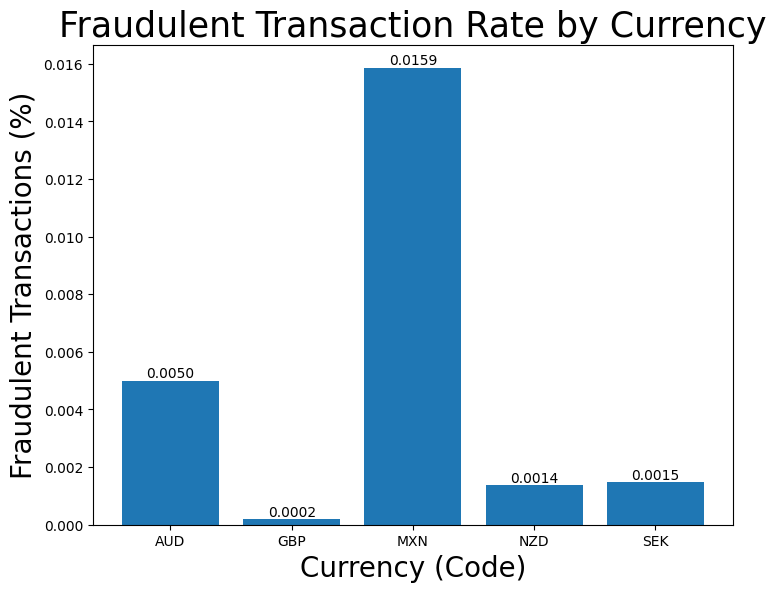

In [176]:
# Group by currency type and plot the mean of the label
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mean_fraud = train_data_df.groupby('currencycode')['label'].mean()
bars_rects = ax.bar(mean_fraud.index, mean_fraud.values)
ax.set_ylabel('Fraudulent Transactions (%)', fontsize=20)
ax.set_xlabel('Currency (Code)', fontsize=20)
ax.set_title('Fraudulent Transaction Rate by Currency', fontsize=25)
autolabel(bars_rects, ax)
plt.show()

### **Frad by Shoppers Origin**

The bar chart shows that for a given shopeper's country of origin, what is the chance that the transaction will be fraudulent. It shows that transactions from Brazil have the highest chance of being fraulent with 6.67% chance. Out of 136 countries, only 12 countries had fraudlent transactions.

<Figure size 10000x2000 with 0 Axes>

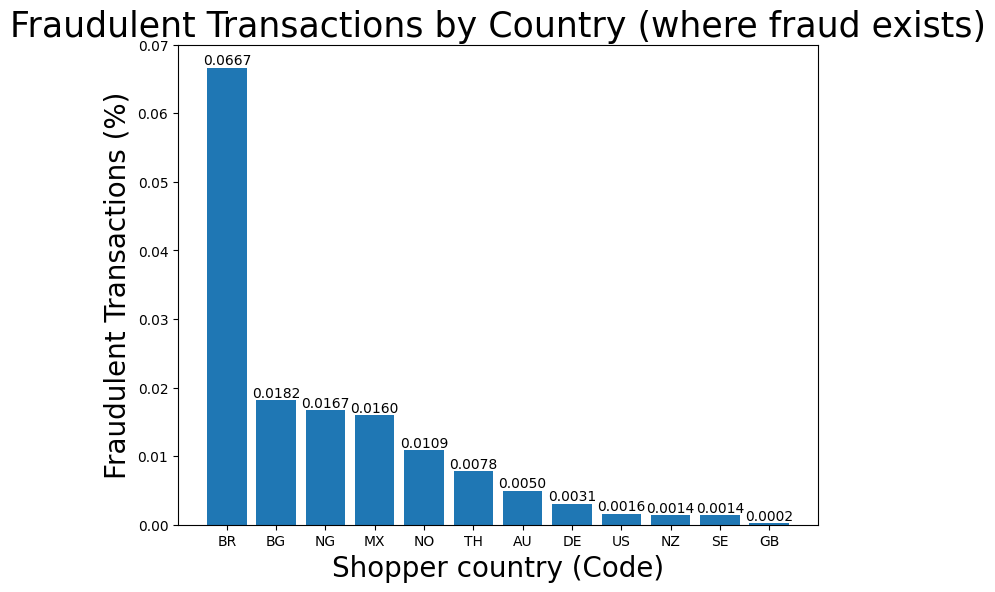

In [177]:
plt.figure(figsize=(100, 20))
fraudulent_mean_data = train_data_df.groupby('shoppercountrycode')['label'].mean()
fraudulent_mean_data = pd.DataFrame(fraudulent_mean_data).reset_index()
fraudulent_mean_data = fraudulent_mean_data[fraudulent_mean_data['label'] > 0.0]
fraudulent_mean_data = fraudulent_mean_data.sort_values(ascending=False, by='label')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
contries = fraudulent_mean_data['shoppercountrycode'].to_list()
mean_fraud = fraudulent_mean_data['label'].to_list()
bars_rects = ax.bar(contries,mean_fraud)
ax.set_ylabel('Fraudulent Transactions (%)', fontsize=20)
ax.set_xlabel('Shopper country (Code)', fontsize=20)
ax.set_title('Fraudulent Transactions by Country (where fraud exists)', fontsize=25)
autolabel(bars_rects, ax)
plt.show()

### Amount of money for transactions

Here the amount of money for a transaction is investigated against the fraudulence label. To do that, Histogram and Box Plot were used. Before that, since the money is in different currencies, we decided to convert them to Euro by using Python's pip package `currency_converter` and used the 02/01/2023 day for the conversion rates. From both graphs we can see that valid transations have much more variety in amount with more outliers of large amounts while fradulent transactions seem to be in a smaller range but higher median than valid transactions.

In [178]:
from datetime import date # datetime works too
from currency_converter import CurrencyConverter
c = CurrencyConverter()

def conv(row, data_conv=date(2023, 1, 2)):
    return c.convert(row['amount'], row['currencycode'], 'EUR', date=data_conv)

converted_train_df = train_data_df.copy(deep=True)
converted_train_df['amount_eur'] = converted_train_df.apply(lambda x: conv(x), axis=1)
converted_train_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur
Id,,,,,,,,,,,,,,,
1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0,5077.287600
2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0,3830.531423
3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0,4394.674489
4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0,17313.550716
6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0,5748.617849


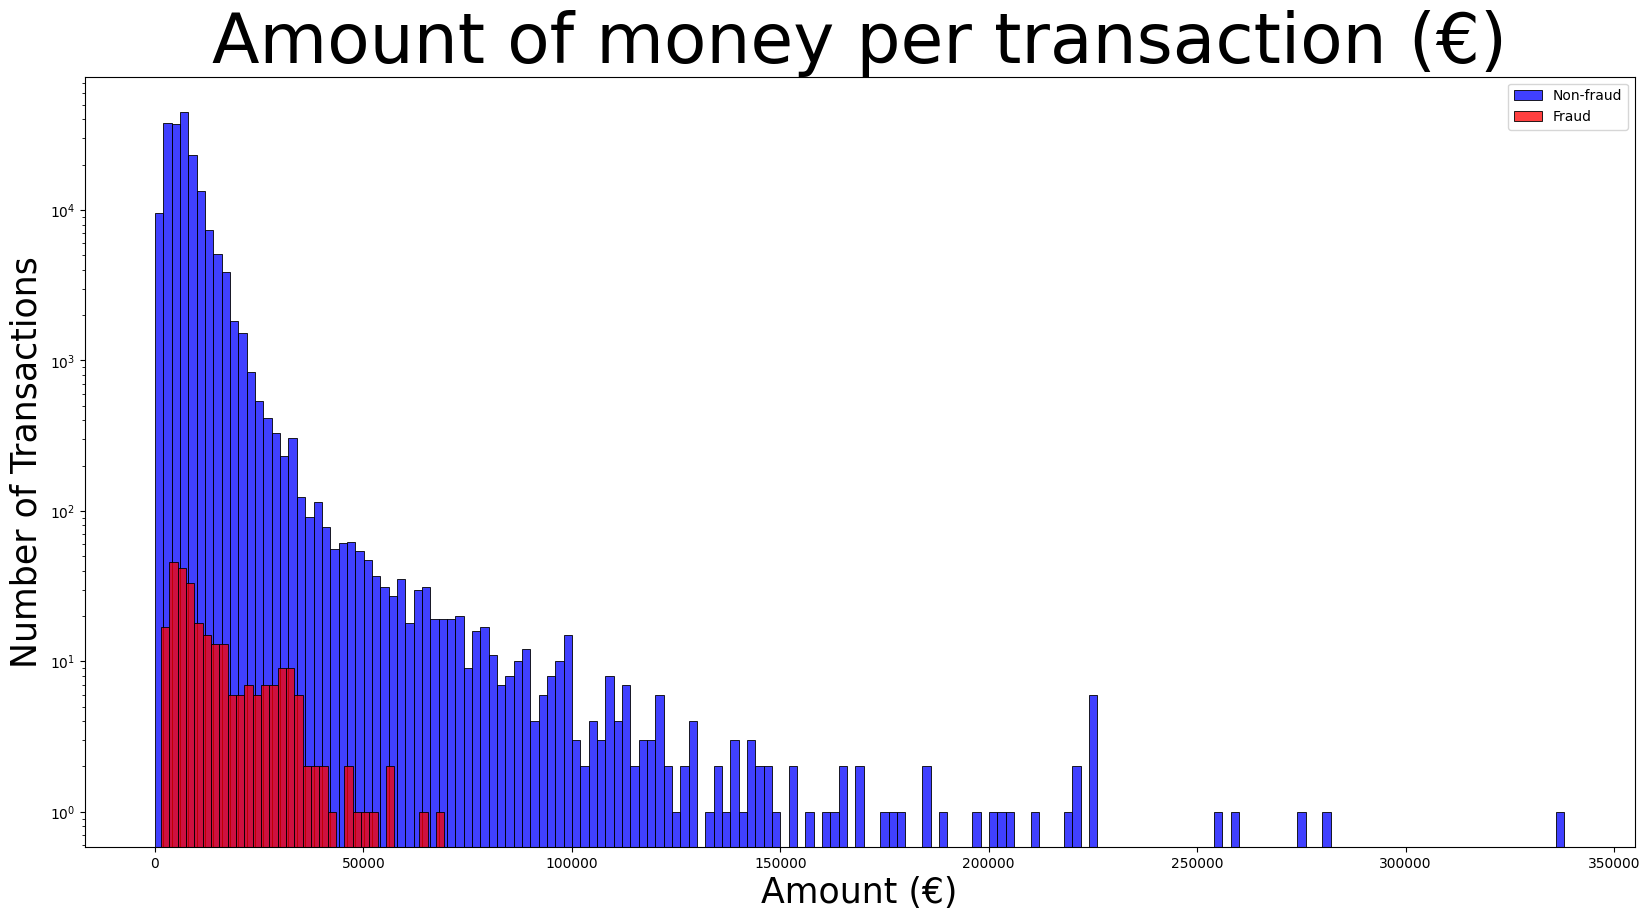

In [179]:
# Plot the distribution of the amount depending on the label
df_amount_fraud = converted_train_df[converted_train_df['label'] == 1]['amount_eur']
df_amount_non_fraud = converted_train_df[converted_train_df['label'] == 0]['amount_eur']
plt.figure(figsize=(20, 10))
sns.histplot(df_amount_non_fraud, color='blue', label='Non-fraud', log_scale=(False, True), binwidth=2000)
sns.histplot(df_amount_fraud, color='red', label='Fraud', log_scale=(False, True), binwidth=2000)
plt.title('Amount of money per transaction (€)', fontsize=50)
plt.ylabel('Number of Transactions', fontsize=25)
plt.xlabel('Amount (€)', fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

In [180]:
df_amount_fraud.max()

68912.71056661563

In [181]:
df_amount_fraud.min()

1435.3056384949932

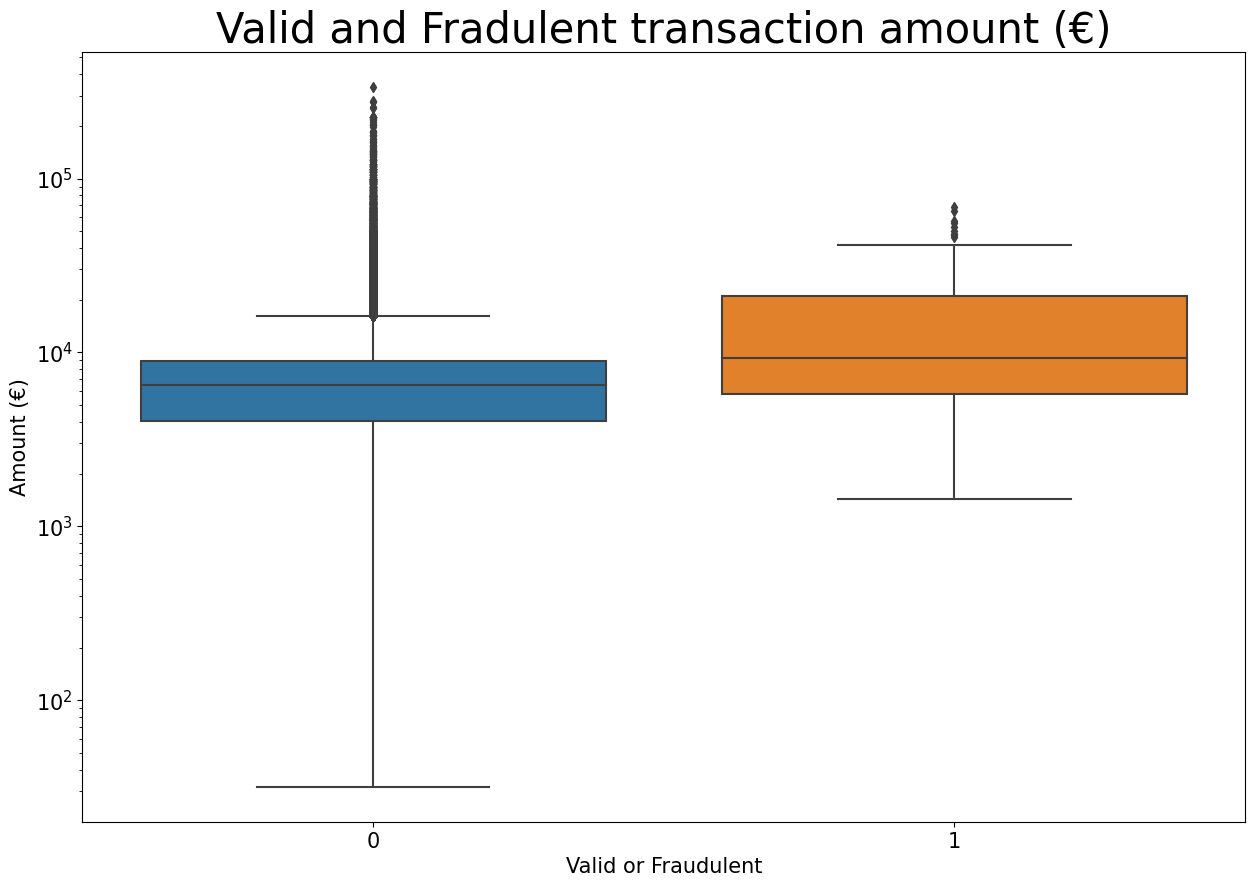

In [182]:
# Create a boxplot of the log of amount depending on the label converted_train_df['amount_eur']
plt.figure(figsize=(15, 10))
sns.boxplot(x='label', y=converted_train_df['amount_eur'], data=converted_train_df)
plt.title('Valid and Fradulent transaction amount (€)', fontsize=30)
plt.ylabel('Amount (€)', fontsize=15)
plt.xlabel("Valid or Fraudulent", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()

### **Correlation between shopper's country of origin and issuer country**

From the bar charts below we can see that a difference between shopper's country of origin and issuer country has a very negledgable increase of fraudulence. 

In [183]:
buyer_with_same_issuer_df = train_data_df[train_data_df['issuercountrycode'] == train_data_df['shoppercountrycode']]
buyer_with_diff_issuer_df = train_data_df[train_data_df['issuercountrycode'] != train_data_df['shoppercountrycode']]

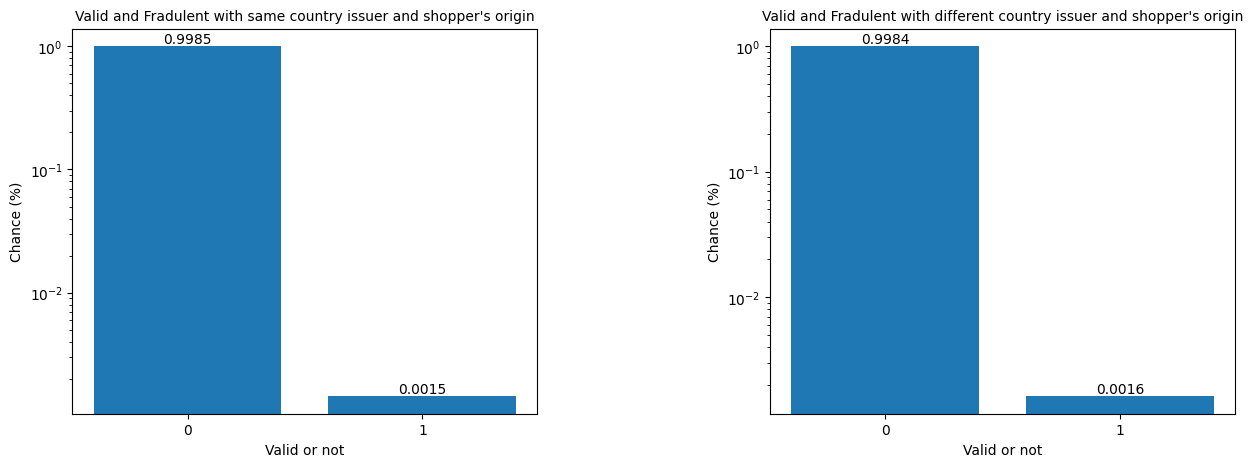

In [184]:
same_code_sr = buyer_with_same_issuer_df["label"].value_counts(normalize=True)
diff_code_sr = buyer_with_diff_issuer_df["label"].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 5))
fig.subplots_adjust(wspace=0.5)

fraud_or_not = same_code_sr.index
percentage_chance = same_code_sr.values
bars_rects = ax1.bar(fraud_or_not, percentage_chance)
ax1.set_ylabel('Chance (%)', fontsize=10)
ax1.set_xlabel("Valid or not", fontsize=10)
ax1.set_title("Valid and Fradulent with same country issuer and shopper's origin", fontsize=10)

autolabel(bars_rects, ax1)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(min(fraud_or_not), max(fraud_or_not)+1, 1.0))


fraud_or_not = diff_code_sr.index
percentage_chance = diff_code_sr.values
bars_rects = ax2.bar(fraud_or_not, percentage_chance)
ax2.set_ylabel('Chance (%)', fontsize=10)
ax2.set_xlabel("Valid or not", fontsize=10)
ax2.set_title("Valid and Fradulent with different country issuer and shopper's origin", fontsize=10)

autolabel(bars_rects, ax2)
ax2.set_xticks(np.arange(min(fraud_or_not), max(fraud_or_not)+1, 1.0))
ax2.set_yscale('log')
plt.show()

## Data preprocessing pipeline

Before we can train our models, we need to preprocess the data first. For this, we have implemented a `CustomDataTransformer` that inherits from the `sklearn`'s classes (`BaseEstimator`, `TransformerMixin`) so that it can be fed into a `sklearn` pipeline.
The pipeline provides a structured, reproducible, and efficient approach to preparing data for machine learning models. It promotes code organization, simplifies integration with model training, and enhances compatibility with other sklearn data processing components (e.g. Normalizer, Standard Scalar, PCA and etc.), leading to more efficient and effective machine learning workflows. These pipelines run `fit_transform(X)` function which 'learns' the data featues and transforms them to the learned format.

Example pipelines can be seen below.

In [185]:
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin, BaseEstimator


def country_equal_feature_eng(df):
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1
    return df


class CustomDataTransformer(BaseEstimator, TransformerMixin):

    def __init__(
        self, currency_conv_func,
        feature_engineering_func=country_equal_feature_eng,
        card_enc=LabelEncoder(),
        ip_enc=LabelEncoder(),
        country_code_enc=LabelEncoder(),
        tx_variant_code_enc=LabelEncoder(),
        currency_code_enc=LabelEncoder(),
        shopper_interaction_enc=LabelEncoder(),
        account_code_enc=LabelEncoder(),
        card_verif_code_supplied=LabelEncoder(),
        mail_id_enc=LabelEncoder()
    ):
        self.card_enc = card_enc
        self.ip_enc = ip_enc
        self.country_code_enc = country_code_enc
        self.tx_variant_code_enc = tx_variant_code_enc
        self.currency_code_enc = currency_code_enc
        self.shopper_interaction_enc = shopper_interaction_enc
        self.account_code_enc = account_code_enc
        self.card_verif_code_supplied = card_verif_code_supplied
        self.mail_id_enc = mail_id_enc

        self.currency_conv_func = currency_conv_func
        self.feature_eng_func = feature_engineering_func

        self.country_codes = None
        self.cleaned_data = None

    def _clean_data(self, df):
        # Cleaning up data inconsisstencies
        df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
        df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
        df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

        df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = '--'
        df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = '--'
        unique_issuer_cc = df['issuercountrycode'].unique()
        unique_shopper_cc = df['shoppercountrycode'].unique()
        both = np.append(unique_issuer_cc, unique_shopper_cc)
        df_countrycodes = pd.DataFrame(both)
        unique_country_codes = df_countrycodes[0].unique()
        self.country_codes = unique_country_codes

        df['amount_eur'] = df.apply(lambda x: self.currency_conv_func(x), axis=1)
        df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
        df.loc[(df['accountcode'] == 'UK'),'accountcode'] = 'GB'
        df.loc[(df['accountcode'] == 'Mexico'),'accountcode'] = 'MX'
        df.loc[(df['accountcode'] == 'Sweden'),'accountcode'] = 'SE'
        df.loc[(df['accountcode'] == 'APAC'),'accountcode'] = 'APAC'

        # Feature Engineering
        if self.feature_eng_func is not None:
            df = self.feature_eng_func(df)
        return df

    def fit(self, X, y=None):
        df = X.copy(deep=True)
        df = self._clean_data(df)

        # 1.Card ID
        self.card_enc.fit(df['card_id'])

        # 2.IP ID
        self.ip_enc.fit(df['ip_id'])

        # 3. Country code
        self.country_code_enc.fit(self.country_codes)

        # 4. TX variant code
        self.tx_variant_code_enc.fit(df['txvariantcode'])

        # 5. Currency code
        self.currency_code_enc.fit(df['currencycode'])

        # 6. Shopper Interaction
        self.shopper_interaction_enc.fit(df['shopperinteraction'])

        # 7. Account code
        self.account_code_enc.fit(df['accountcode'])
        df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        self.card_verif_code_supplied.fit(df['cardverificationcodesupplied'])
        df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(
            df.cardverificationcodesupplied
        )

        # 9. Email ID
        self.mail_id_enc.fit(df['mail_id'])
        df['mail_id'] = self.mail_id_enc.transform(df.mail_id)

        return self

    def transform(self, X):
        df = X.copy(deep=True)
        df = self._clean_data(df)
        # 1.Card ID
        df['card_id'] = self.card_enc.transform(df.card_id)

        # 2.IP ID
        df['ip_id'] = self.ip_enc.transform(df.ip_id)

        # 3. Country code
        df['issuercountrycode'] = self.country_code_enc.transform(df.issuercountrycode)
        df['shoppercountrycode'] = self.country_code_enc.transform(df.shoppercountrycode)

        # 4. TX variant code
        df['txvariantcode'] = self.tx_variant_code_enc.transform(df.txvariantcode)

        # 5. Currency code
        df['currencycode'] = self.currency_code_enc.transform(df.currencycode)

        # 6. Shopper Interaction
        df['shopperinteraction'] = self.shopper_interaction_enc.transform(
            df.shopperinteraction
        )

        # 7. Account code
        df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(
            df.cardverificationcodesupplied
        )

        # 9. Email ID
        df['mail_id'] = self.mail_id_enc.transform(df.mail_id)

        return df

In [186]:
# Regular pipeline
pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(
        conv, feature_engineering_func=country_equal_feature_eng)
    )
])

# fit the pipeline to your data and transform it
transformed_data_df = pipeline.fit_transform(train_data_df)
transformed_data_df

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,countries_equal
Id,,,,,,,,,,,,,,,,
1,50,2,546097.0,4500.0,1,50,1,1,1,1,17805,12538,105460,0,5077.287600,1
2,50,3,557349.0,3395.0,1,50,1,1,1,1,115620,107432,29882,0,3830.531423,1
3,50,2,542011.0,3895.0,1,50,1,1,1,1,84651,87293,123743,0,4394.674489,1
4,50,8,465943.0,15345.0,1,50,0,0,0,1,99845,147089,14712,0,17313.550716,1
6,50,8,475127.0,5095.0,1,50,1,1,1,1,122624,56390,75841,0,5748.617849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237030,50,2,522948.0,10900.0,1,50,1,1,1,1,98176,111864,159778,0,12298.318854,1
237031,50,8,475128.0,1895.0,1,50,1,1,1,1,154237,163508,83649,0,2138.102223,1
237032,50,8,475130.0,3195.0,1,50,1,1,1,1,71272,144408,4558,0,3604.874196,1


In [187]:
# create a pipeline object with scaling
scale_pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng)),  # apply the custom function
    ('scaler', StandardScaler()),  # standardize the data
])

# fit the pipeline to your data and transform it
scaled_data = scale_pipeline.fit_transform(train_data_df)
print(f"Size: {scaled_data.shape}")
scaled_data

Size: (189628, 16)


array([[-0.20504415, -1.66721083,  1.70021127, ..., -0.03817856,
        -0.3685056 ,  0.1733803 ],
       [-0.20504415, -1.29012909,  2.01371459, ..., -0.03817856,
        -0.55193108,  0.1733803 ],
       [-0.20504415, -1.66721083,  1.5863671 , ..., -0.03817856,
        -0.46893313,  0.1733803 ],
       ...,
       [-0.20504415,  0.59527961, -0.27707186, ..., -0.03817856,
        -0.58513027,  0.1733803 ],
       [-0.20504415,  0.59527961, -0.27707186, ..., -0.03817856,
         0.19505052,  0.1733803 ],
       [-1.63708174, -1.66721083,  1.02126985, ..., -0.03817856,
        -0.07994351,  0.1733803 ]])

In [188]:
# create a pipeline object with scaling and PCA
pipeline_pca = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng)),  # apply the custom function
    ('scaler', StandardScaler()),  # standardize the data
    ('pca', PCA(n_components=3)),  # reduce the dimensionality to 3 using PCA
])

# fit the pipeline to your data and transform it
transformed_pca_data = pipeline_pca.fit_transform(train_data_df)
print(f"Size: {transformed_pca_data.shape}")
transformed_pca_data

Size: (189628, 3)


array([[-0.0169061 ,  1.5166563 , -1.6775315 ],
       [-0.06796116,  1.46827287, -1.59275373],
       [-0.06218349,  1.45587333, -1.60876709],
       ...,
       [-0.54148602, -0.86620103, -0.11707933],
       [-0.47110574, -0.75736598, -0.1333725 ],
       [-2.74722096,  2.67795547, -1.14284702]])

## Training Models

After pre-processing the data we would like see how our white-box methods to see how they perform in this unballanced setting.

In [189]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


def train_classifier_and_plot(classifier, data_quad, cv_func=None):
    X_train_data, X_test_data, y_train_data, y_test_data = data_quad
    if cv_func is None:
        classifier.fit(X_train_data, y_train_data)
    else:
        classifier = cv_func(X, y, classifier,
                             scoring='accuracy',
                             k=10
        )

    y_predictions = classifier.predict(X_test_data)
    y_predictions_proba = classifier.predict_proba(X_test_data)[:, 1]

    print(classification_report(y_test_data, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test_data, y_predictions) * 100:.2f}")

    fpr, tpr, _ = roc_curve(y_test_data, y_predictions_proba)
    roc_auc = auc(fpr, tpr)

    ConfusionMatrixDisplay.from_predictions(y_test_data, y_predictions)
    plt.show()
    return fpr, tpr, roc_auc, classifier


def plot_roc_curves(plot_title, *plot_tuples):
    plt.figure(0).clf()
    for plot_tuple in plot_tuples:
        plt.plot(plot_tuple[0], plot_tuple[1], label=plot_tuple[2])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend()
    plt.show()

In [190]:
from sklearn.model_selection import train_test_split

X = transformed_data_df.drop(['label'], axis=1)
y = transformed_data_df['label']

train_test_pairs = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.00      0.00      0.00        64

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.83


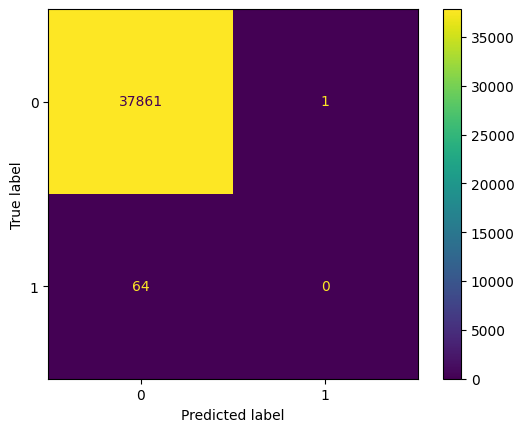

In [191]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_fpr, logreg_tpr, logreg_roc_auc, _ = train_classifier_and_plot(
    logreg_classifier, train_test_pairs
)

### Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.25      0.09      0.14        64

    accuracy                           1.00     37926
   macro avg       0.62      0.55      0.57     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.80


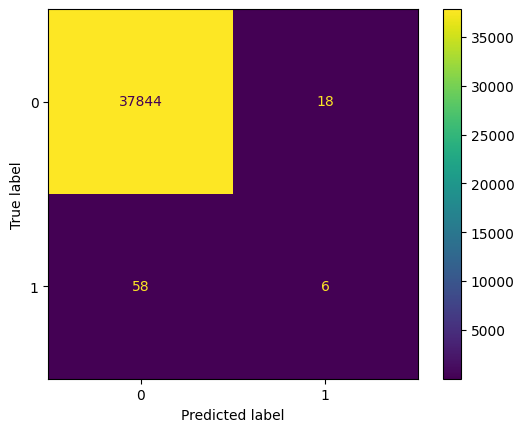

In [192]:
dtree_classifier = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree_fpr, dtree_tpr, dtree_roc_auc, _ = train_classifier_and_plot(
    dtree_classifier,
    train_test_pairs
)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       0.00      0.00      0.00        64

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.83


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


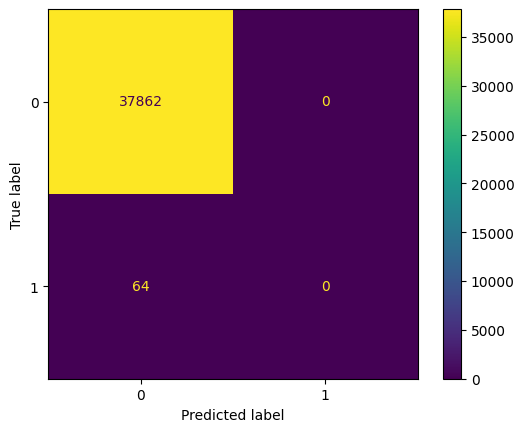

In [193]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_fpr, forest_tpr, forest_roc_auc, _ = train_classifier_and_plot(
    forest_classifier,
    train_test_pairs
)

### ROC curve for the original dataset

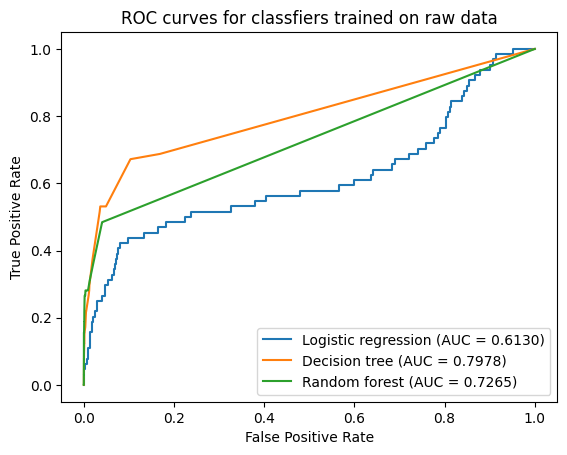

In [194]:
plot_roc_curves(
    "ROC curves for classfiers trained on raw data",
    (logreg_fpr, logreg_tpr, f"Logistic regression (AUC = {logreg_roc_auc:.4f})"),
    (dtree_fpr, dtree_tpr, f"Decision tree (AUC = {dtree_roc_auc:.4f})"),
    (forest_fpr, forest_tpr, f"Random forest (AUC = {forest_roc_auc:.4f})")
)

## Conclusion

As seen in the from the traing results, the classifiers have managed to get an accuracy score very close to 100% (by about 0.2%). However, this is very misleading to only look at the accucary statistic as techiques identified very few, if at all, fraudulent transactions as fraudlent. The data has less than 0.04% of fradulent cases which makes the model bias for viewing almost all transactions as valid.

This shows that we need additional tweaking by adding new data points so that we can improve the true negative case detection.

# SMOTEing

#### Author: Krzysztof Baran

In [195]:
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors

def nearest_neighbours(data_in, k=5):
    kNN = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto').fit(data_in)
    indices = kNN.kneighbors(data_in, return_distance=False)
    return indices

example_np = [[0.0,1.0,3.2], [3.4,0.2,1.1], [0.6,1.0,1.0]]

ind_matrix = nearest_neighbours(example_np, k=3)
ind_matrix

array([[0, 2, 1],
       [1, 2, 0],
       [2, 0, 1]])

## SMOTE implementation

In [196]:
import random

def smote_custom(train_data_df, k=5, sample_num=100, random_state=None):
    kNN_matrix = nearest_neighbours(train_data_df, k=k)
    rng = random.Random() if random_state is None else random.Random(random_state)

    X = train_data_df.to_numpy()

    X_new = []

    for i, x_sample in enumerate(X):
        for _ in range(sample_num):
            rand_nn = rng.randrange(1, k)

            nn_point = X[kNN_matrix[i][rand_nn]]

            diff = nn_point - x_sample
            gap = rng.uniform(0, 1)

            new_data_point = x_sample + gap * diff
            X_new.append(new_data_point)
    X_new = np.array(X_new)
    genereated_samples_df = pd.DataFrame(X_new, columns=train_data_df.columns)
    return genereated_samples_df

## Data Division

In [197]:
import time
from sklearn.model_selection import train_test_split

X = transformed_data_df.drop(['label'], axis=1)
y = transformed_data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_fraud = X_train.loc[y_train == 1]

start = time.time()
X_fraud_smote = smote_custom(X_train_fraud.copy(), sample_num=750, random_state=0)
smote_time = time.time() - start

print(f'SMOTE time: {smote_time:.2f}s')

X_fraud_smote.head()

SMOTE time: 1.52s


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
0,40.318176,7.273863,464041.407108,14513.409746,0.757954,40.318176,0.242046,0.242046,0.0,0.757954,62140.252193,27894.138326,110005.541376,14234.760358,1.0
1,11.619375,5.121453,431172.670333,17813.77186,0.040484,11.619375,0.959516,0.959516,0.0,0.040484,67461.727367,32053.31206,140962.220535,11613.601478,1.0
2,26.197365,6.214802,447868.842705,16137.302968,0.404934,26.197365,0.595066,0.595066,0.0,0.404934,64758.603503,29940.596805,125237.306771,12945.058807,1.0
3,104.8444,7.9034,481988.579124,24968.159963,2.9034,104.8444,1.0,1.0,0.0,0.0,93725.170464,24657.86484,156675.321727,14812.260734,1.0
4,67.17144,6.750146,461067.400733,22200.350684,1.750146,67.17144,1.0,1.0,0.0,0.0,83412.389972,27688.616001,151127.786211,13482.979233,1.0


In [198]:
from sklearn.utils import shuffle

before_smote_valid = len(y_train[y_train == 0])
before_smote_fraud = len(y_train[y_train == 1])

X_train = pd.concat([X_train, X_fraud_smote])
y_train = pd.concat([
    y_train,
    pd.Series(1, index=range(len(X_fraud_smote)))
])

X_train, y_train = shuffle(X_train, y_train, random_state=0)

after_smote_valid = len(y_train[y_train == 0])
after_smote_fraud = len(y_train[y_train == 1])

results_smote_matrix = pd.DataFrame([
    ["before", before_smote_valid, before_smote_fraud],
    ["after", after_smote_valid, after_smote_fraud]],
    columns=["SMOTE", "valid", "fraud"])
results_smote_matrix.set_index('SMOTE', inplace=True)
results_smote_matrix

,valid,fraud
SMOTE,,
before,151490,212
after,151490,159212


In [199]:
train_test_pairs = (X_train, X_test, y_train, y_test)

## Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     37862
           1       0.01      0.66      0.02        64

    accuracy                           0.89     37926
   macro avg       0.50      0.77      0.48     37926
weighted avg       1.00      0.89      0.94     37926

Accuracy: 88.77


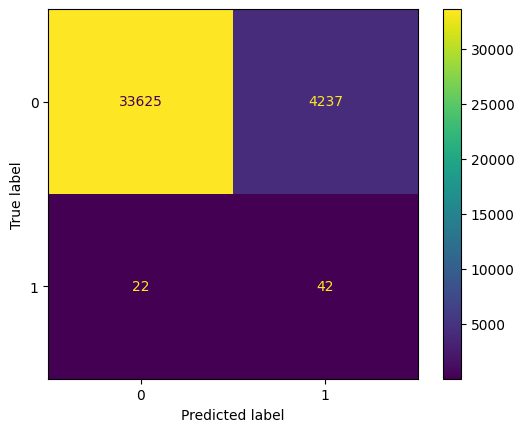

In [204]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_fpr_smote, logreg_tpr_smote, logreg_roc_auc_smote, _ = train_classifier_and_plot(
    logreg_classifier, train_test_pairs
)

## Decision Tree

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37862
           1       0.02      0.59      0.04        64

    accuracy                           0.96     37926
   macro avg       0.51      0.78      0.51     37926
weighted avg       1.00      0.96      0.98     37926

Accuracy: 95.72


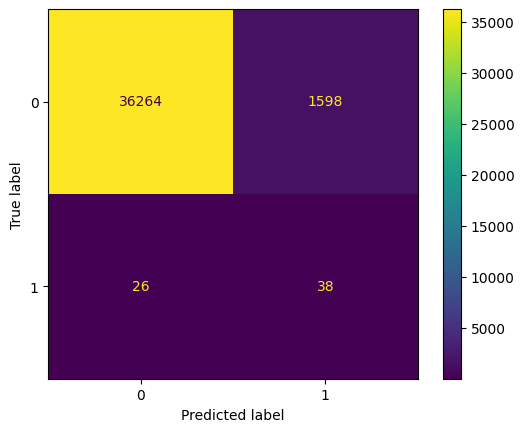

In [205]:
dtree_classifier = DecisionTreeClassifier(max_depth=5, random_state=0)
dtree_fpr_smote, dtree_tpr_smote, dtree_roc_auc_smote, _ = train_classifier_and_plot(
    dtree_classifier, train_test_pairs
)

## Random Forest

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37862
           1       0.03      0.61      0.05        64

    accuracy                           0.96     37926
   macro avg       0.51      0.79      0.52     37926
weighted avg       1.00      0.96      0.98     37926

Accuracy: 96.26


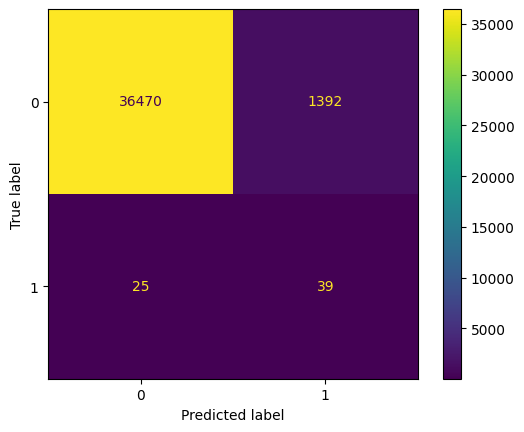

In [206]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_fpr_smote, forest_tpr_smote, forest_roc_auc_smote, _ = train_classifier_and_plot(
    forest_classifier, train_test_pairs
)

## ROC curve for the SMOTED dataset

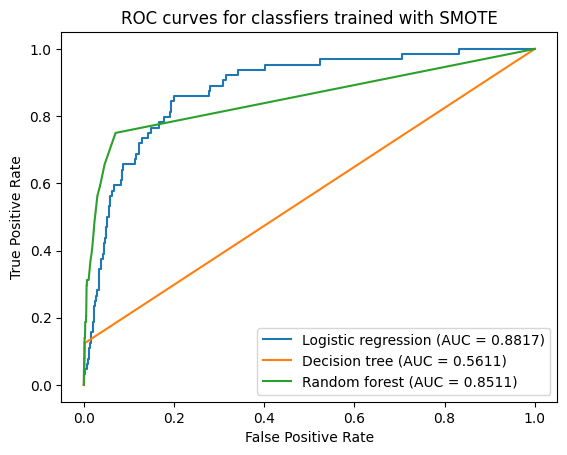

In [ ]:
plot_roc_curves(
    "ROC curves for classfiers trained with SMOTE",
    (logreg_fpr_smote, logreg_tpr_smote, f"Logistic regression (AUC = {logreg_roc_auc_smote:.4f})"),
    (dtree_fpr_smote, dtree_tpr_smote, f"Decision tree (AUC = {dtree_roc_auc_smote:.4f})"),
    (forest_fpr_smote, forest_tpr_smote, f"Random forest (AUC = {forest_roc_auc_smote:.4f})")
)

## Conclusion



As we can see, generally the SMOTEing helped to to be more alert for fraudeulent transactions which increaced our recall compared to before without any previous.

However, SMOTEing has led to an increase in the False Positive Rate (FPR) and our percision which is not very desirable from the point of view of a bank customer as falsely flagging someone's transaction as fraudlent, as that would require an expensive manual intervention with an explanation from the bank. On top of that, it could harm the customer's trust.

As seen from our results, we can see that in this case Logistic Regression seems to perform best as it assumes a linear relationship between the features and the target variable which is the case in our Label Encoding method. However, due to a very low percision, it would not be recommended to use this model as that could cause a lot of manual reviews.

Although the results from these classifers are not ideal, we have shown that SMOTE helps to improve the performance for all tested classifiers and seems to be a good first step to deal with imbalanced data. However, because SMOTE introduces new data points, it may not be aware of hyperplane boundries and introduce some new points that can confuse the classifers. Therefore, an extra setp would be needed, e.g. using Tomek links to remove majority points too close to minority points.

# Rank Swapping

#### Author: Michał Okoń

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

# 4. Classification task

Pure SMOTE has not performed as well as we would like. In order to improve the recall, we would like to remove Nearest Neightbours of majority and mirority class which cause the data to be noisey or bounries to be not very well defined. These are called Tomek Links. A link between point `a` and `b` is a Tomek Link iff:
1. instance `a`’s nearest neighbor is `b`
2. instance `b`’s nearest neighbor is `a`
3. instances `a` and `b` belong to different classes.

In [232]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


def smote_tomek_link(X_train_data, y_train_data):
    smote = SMOTE(sampling_strategy='minority', random_state=0)
    tomek = TomekLinks(n_jobs=-1)
    smote_tomek = SMOTETomek(smote=smote, tomek=tomek, random_state=0, n_jobs=-1)
    return smote_tomek.fit_resample(X_train_data, y_train_data)


X = transformed_data_df.drop(['label'], axis=1)
y = transformed_data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

before_smote_valid = len(y_train[y_train == 0])
before_smote_fraud = len(y_train[y_train == 1])

X_train, y_train = smote_tomek_link(X_train, y_train)


after_smote_valid = len(y_train[y_train == 0])
after_smote_fraud = len(y_train[y_train == 1])

results_smote_matrix = pd.DataFrame([
    ["before", before_smote_valid, before_smote_fraud],
    ["after", after_smote_valid, after_smote_fraud]],
    columns=["SMOTE", "valid", "fraud"])
results_smote_matrix.set_index('SMOTE', inplace=True)
results_smote_matrix

,valid,fraud
SMOTE,,
before,151490,212
after,151490,151489


## Training a Whitebox classifier - Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       1.00      0.02      0.03        64

    accuracy                           1.00     37926
   macro avg       1.00      0.51      0.51     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.83


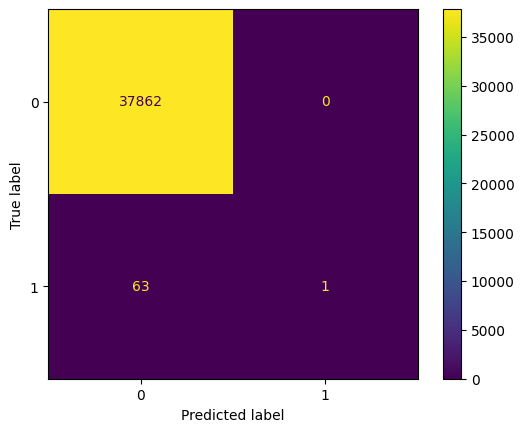

In [233]:
from sklearn.model_selection import KFold, cross_validate


def k_fold_cross_validation(X_data_train, y_data_train, model, scoring, k=10):
    cv = KFold(n_splits=k, random_state=0, shuffle=True)
    res = cross_validate(model, X_data_train, y_data_train, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    best_index = np.argmax(res['test_score'])
    model = res['estimator'][best_index]
    return model

train_test_pairs = (X_train, X_test, y_train, y_test)

dtree_classifier = DecisionTreeClassifier(max_depth=3, random_state=0)
dtree_cv_fpr, dtree_cv_tpr, dtree_cv_roc_auc, dtree_classifier = train_classifier_and_plot(
    dtree_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)

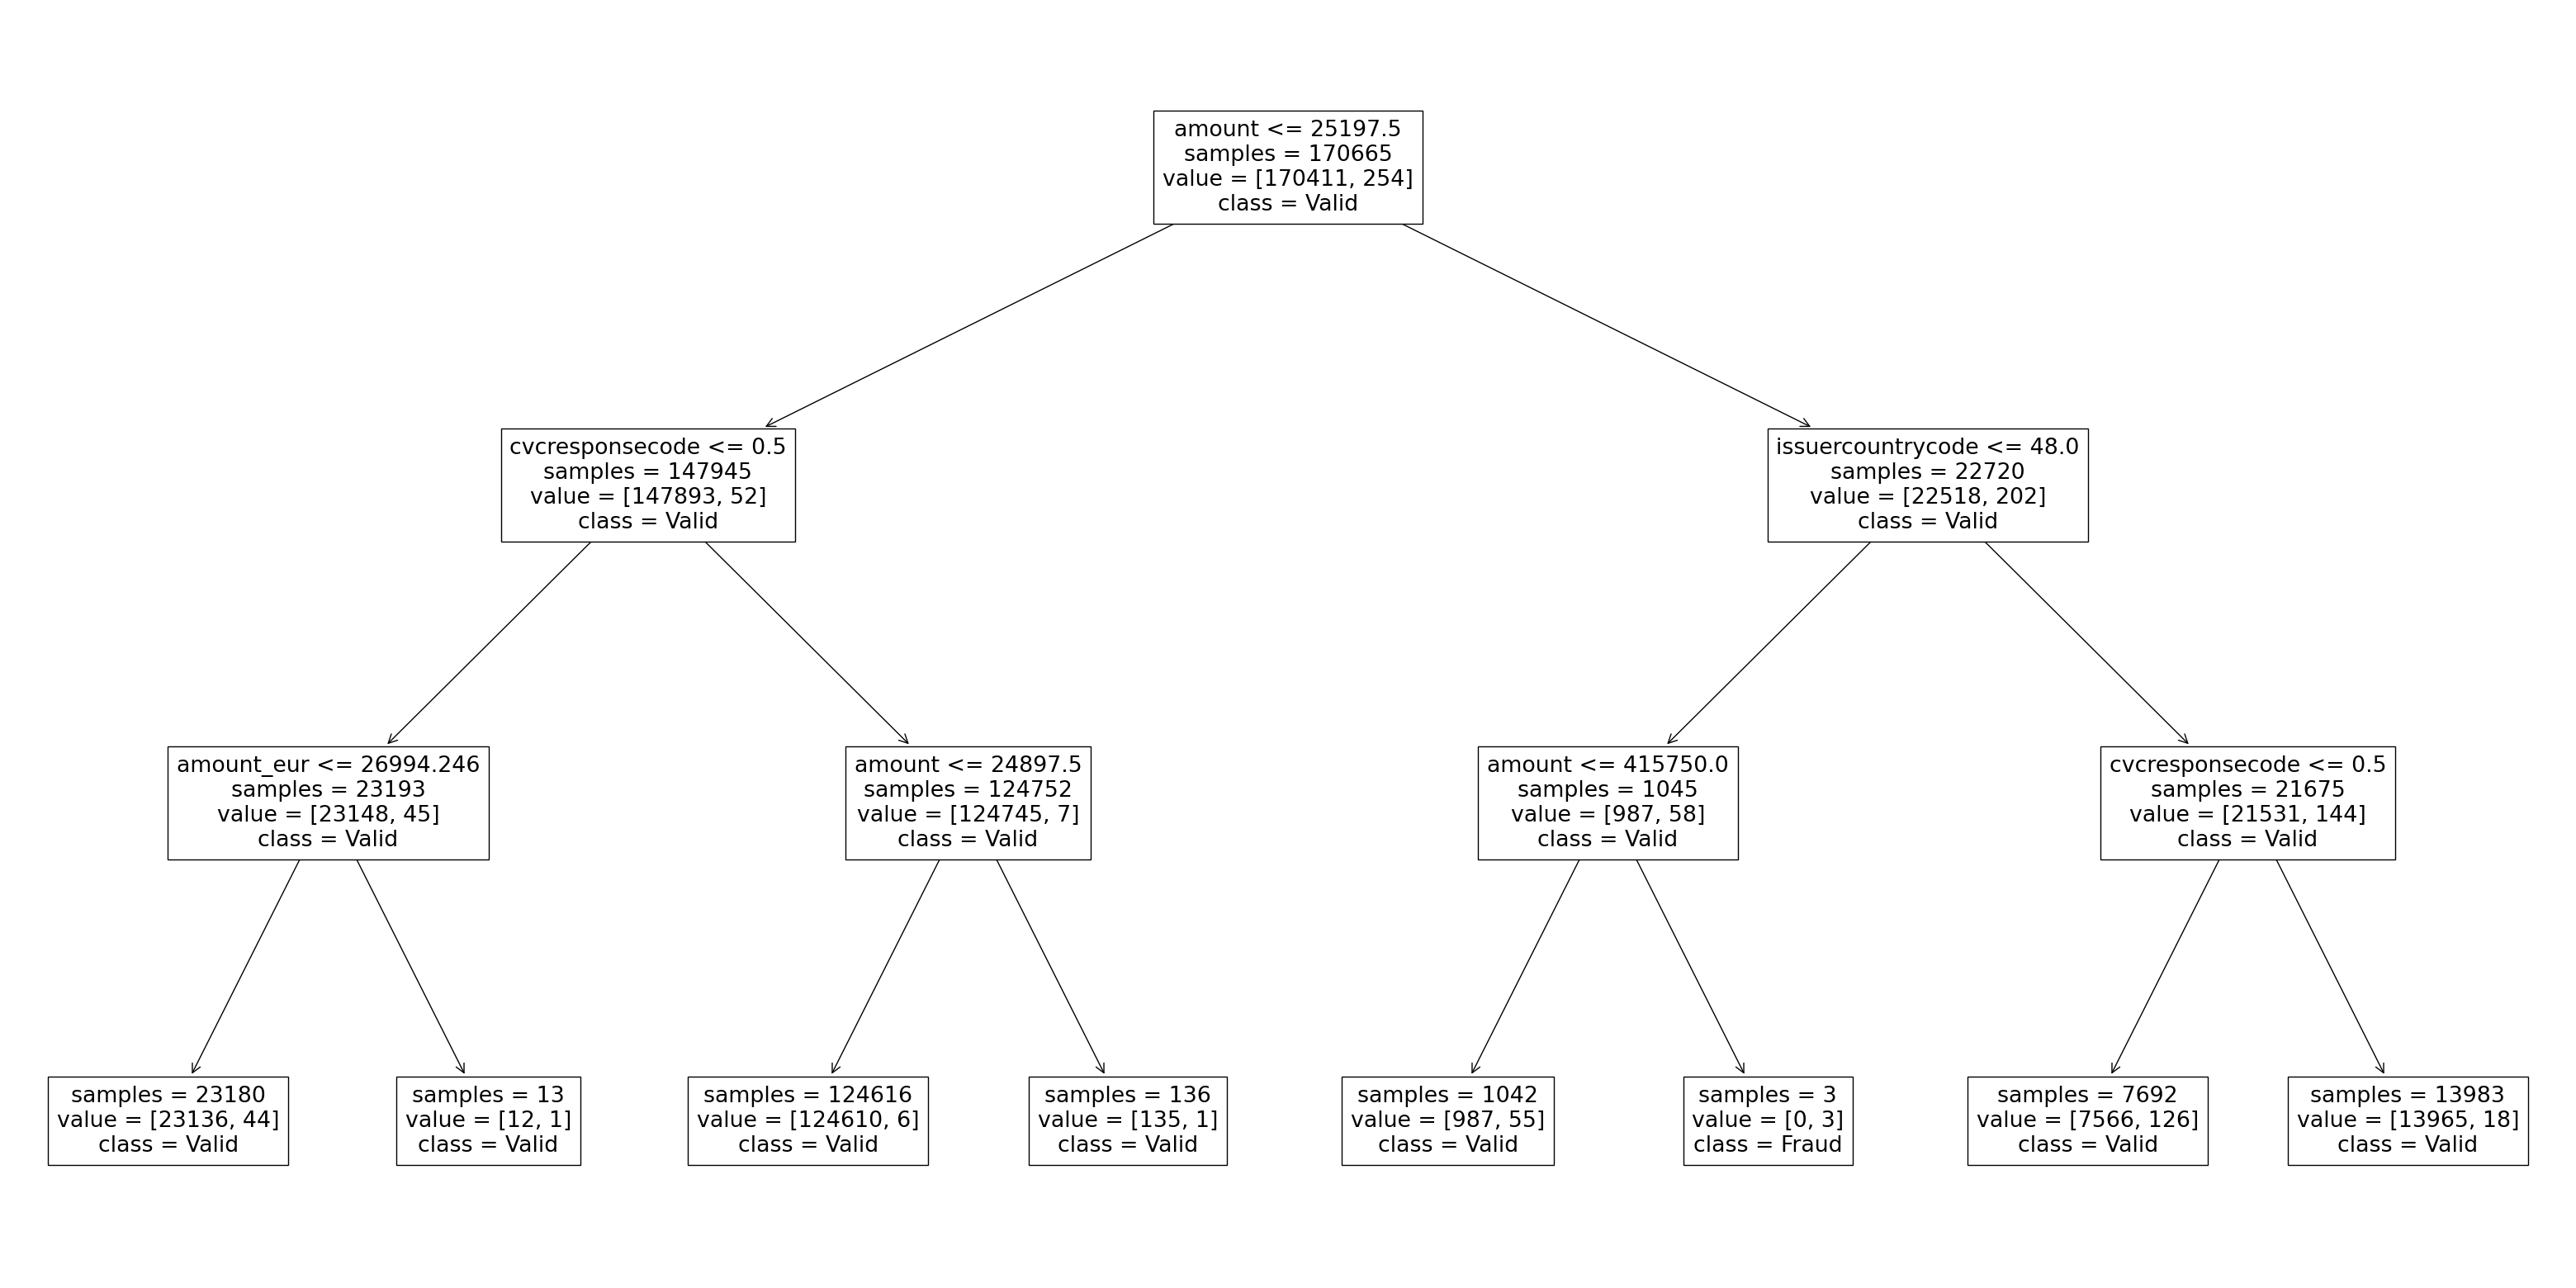

In [215]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40, 20))
plot_tree(dtree_classifier, feature_names=X_train.columns, class_names=['Valid', 'Fraud'], impurity=False)
plt.show()

In [210]:
X_test_withpredictions = X_test.copy()
X_test_withpredictions['predicted_label'] = dtree_classifier.predict(X_test_withpredictions)
X_test_withpredictions = X_test_withpredictions[X_test_withpredictions['predicted_label'] == 1]
X_test_withpredictions.head(5)

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal,predicted_label
Id,,,,,,,,,,,,,,,,
89694,10,8,456475.0,19600.0,0,10,1,1,0,0,110726,34962,76473,12484.871648,1,1
215492,101,2,549949.0,119900.0,2,101,1,1,0,2,92846,158759,72232,5755.623614,1,1
200294,101,2,548234.0,149700.0,2,101,1,1,0,2,103714,6363,43237,7186.128899,1,1
95022,101,2,551238.0,155800.0,2,101,1,1,0,2,117568,157041,136647,7478.950451,1,1
80360,101,8,415231.0,304130.0,2,101,1,1,0,2,121826,140267,89798,14599.314510,1,1


## Explaining the whitebox classifier

From the figure above and the data frame, we can see how the decision the Decision Tree classifier makes. This example has a max depth of 3 as to make it eaisly explainable.

We can see from the tree that there is only one path to get a fraudulent classification where the amount can be between 251.98 and 415.75 EURO and having issuer country encoded label equal or lower than 48.

## Blackbox classifier

## ROC Curve for White-Box and Black-Box

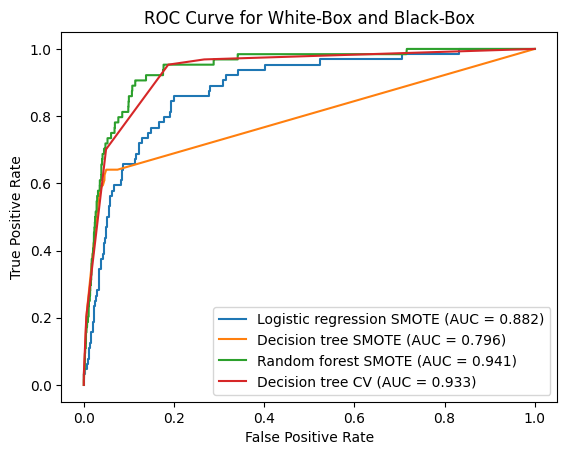

In [216]:
plot_roc_curves(
    "ROC Curve for White-Box and Black-Box",
    (logreg_fpr_smote, logreg_tpr_smote, f"Logistic regression SMOTE (AUC = {logreg_roc_auc_smote:.3f})"),
    (dtree_fpr_smote, dtree_tpr_smote, f"Decision tree SMOTE (AUC = {dtree_roc_auc_smote:.3f})"),
    (forest_fpr_smote, forest_tpr_smote, f"Random forest SMOTE (AUC = {forest_roc_auc_smote:.3f})"),
    (dtree_cv_fpr, dtree_cv_tpr, f"Decision tree CV (AUC = {dtree_cv_roc_auc:.3f})"),
)

## Comparison

## Kaggle competition

In [218]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, Normalizer

pipeline_new_encoders = Pipeline([
    (
        'custom_transform',
        CustomDataTransformer(
            conv,
            feature_engineering_func=country_equal_feature_eng,
            card_enc=Normalizer(),
            ip_enc=Normalizer(),
            country_code_enc=OneHotEncoder(),
            tx_variant_code_enc=LabelEncoder(),
            currency_code_enc=OneHotEncoder(),
            shopper_interaction_enc=LabelEncoder(),
            account_code_enc=LabelEncoder(),
            card_verif_code_supplied=LabelEncoder(),
            mail_id_enc=Normalizer()
        )
    )
])

# fit the pipeline to your data and transform it
transformed_data_df = pipeline.fit_transform(train_data_df)
transformed_data_df

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,countries_equal
Id,,,,,,,,,,,,,,,,
1,50,2,546097.0,4500.0,1,50,1,1,1,1,17805,12538,105460,0,5077.287600,1
2,50,3,557349.0,3395.0,1,50,1,1,1,1,115620,107432,29882,0,3830.531423,1
3,50,2,542011.0,3895.0,1,50,1,1,1,1,84651,87293,123743,0,4394.674489,1
4,50,8,465943.0,15345.0,1,50,0,0,0,1,99845,147089,14712,0,17313.550716,1
6,50,8,475127.0,5095.0,1,50,1,1,1,1,122624,56390,75841,0,5748.617849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237030,50,2,522948.0,10900.0,1,50,1,1,1,1,98176,111864,159778,0,12298.318854,1
237031,50,8,475128.0,1895.0,1,50,1,1,1,1,154237,163508,83649,0,2138.102223,1
237032,50,8,475130.0,3195.0,1,50,1,1,1,1,71272,144408,4558,0,3604.874196,1


In [220]:
X = transformed_data_df.drop(['label'], axis=1)
y = transformed_data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

before_smote_valid = len(y_train[y_train == 0])
before_smote_fraud = len(y_train[y_train == 1])

smote = SMOTE(sampling_strategy='minority', random_state=0)
tomek = TomekLinks(n_jobs=-1)
smote_tomek = SMOTETomek(smote=smote, tomek=tomek, random_state=0, n_jobs=-1)

X_train, y_train = smote_tomek.fit_resample(X_train, y_train)


after_smote_valid = len(y_train[y_train == 0])
after_smote_fraud = len(y_train[y_train == 1])

results_smote_matrix = pd.DataFrame([
    ["before", before_smote_valid, before_smote_fraud],
    ["after", after_smote_valid, after_smote_fraud]],
    columns=["SMOTE", "valid", "fraud"])
results_smote_matrix.set_index('SMOTE', inplace=True)

train_test_pairs = [X_train, X_test, y_train, y_test]


results_smote_matrix

,valid,fraud
SMOTE,,
before,151490,212
after,151490,151489


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       1.00      0.69      0.81        64

    accuracy                           1.00     37926
   macro avg       1.00      0.84      0.91     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.95


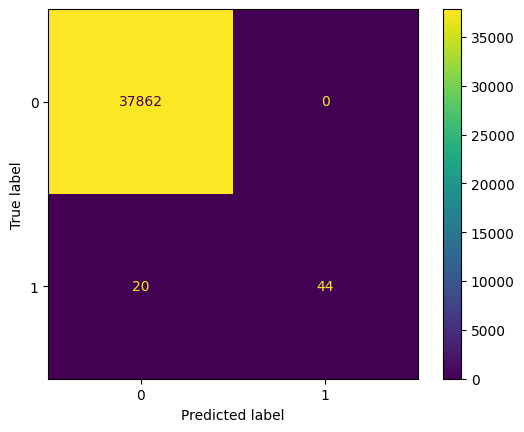

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37862
           1       1.00      0.86      0.92        64

    accuracy                           1.00     37926
   macro avg       1.00      0.93      0.96     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.98


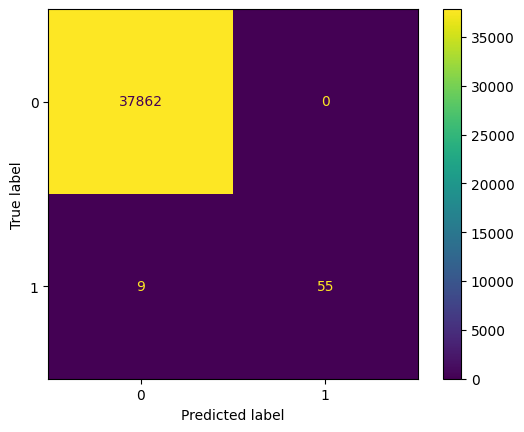

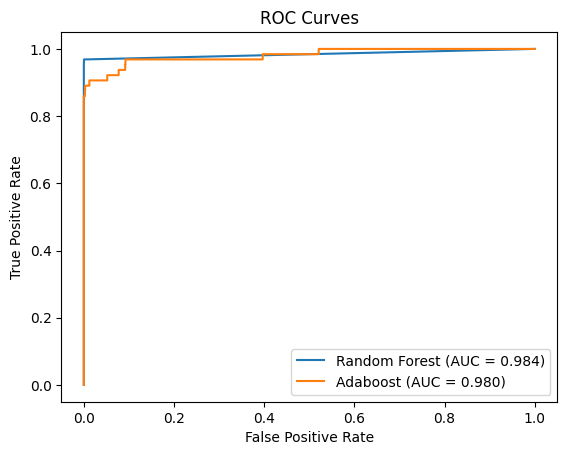

In [228]:
forest_classifier = RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=-1, n_estimators=10)
adaboost_classifier = AdaBoostClassifier(base_estimator=forest_classifier, random_state=0, n_estimators=20)

forest_cv_fpr, forest_cv_tpr, forest_cv_roc_auc, forest_classifier = train_classifier_and_plot(
    forest_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)

adaboost_cv_fpr, adaboost_cv_tpr, adaboost_cv_roc_auc, adaboost_classifier = train_classifier_and_plot(
    adaboost_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)


plot_roc_curves(
    "ROC Curves",
    (forest_cv_fpr, forest_cv_tpr, f"Random Forest (AUC = {forest_cv_roc_auc:.3f})"),
    (adaboost_cv_fpr, adaboost_cv_tpr, f"Adaboost (AUC = {adaboost_cv_roc_auc:.3f})"),
)

In [234]:
transformed_test_data_df = pipeline.transform(test_data_df)
test_pred = adaboost_classifier.predict(transformed_test_data_df)
print(np.sum(test_pred))

0


# 5. Bonus task 

### 5a. Provide code and report below